In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

Using backend: tensorflow.compat.v1

2023-07-26 23:31:38.314112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-07-26 23:31:41.624247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:31:41.707358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:31:41.707595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [21]:
l = 3
m = 2

In [22]:
def z_component(phi):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(phi * m * 1j)

In [23]:
def theta_part(theta):
    # 2*pi is already at the z_component
    normalization_constant = ((-1) ** m) * np.sqrt(((2 * l + 1) / 2) * (np.math.factorial(l - m) / np.math.factorial(l + m)))
    legendre_values = []
    for i in theta:
        legendre_polynomials, _ = sp.lpmn(m, l, np.cos(i[0]))
        legendre = legendre_polynomials[m, l]
        legendre_values.append([legendre])
    legendre_values = np.array(legendre_values)
    
    return normalization_constant * legendre_values

In [24]:
def spherical_harmonic(x):
    theta, phi = x[:, 0:1], x[:, 1:2]
    
    legendre_component = theta_part(theta)
    phi_component = z_component(phi)
    
    return legendre_component * phi_component

In [25]:
domain = dde.geometry.Interval(0, np.pi)

In [26]:
num_train = 64
num_test = 100
data = dde.data.Function(domain, theta_part, num_train, num_test)

In [27]:
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN([1] + [50] * 5 + [1], activation, initializer)

In [28]:
model = dde.Model(data, net)
model.compile('adam', lr=0.001, metrics=['l2 relative error'])

Compiling model...
Building feed-forward neural network...
'build' took 0.085575 s

'compile' took 0.273410 s



2023-07-26 23:35:20.458158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:35:20.458507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 23:35:20.458760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [29]:
loss_history, train_state = model.train(iterations=10000)

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [4.54e-01]    [4.57e-01]    [1.06e+00]    
1000      [1.32e-04]    [1.20e-04]    [1.72e-02]    
2000      [4.54e-05]    [4.06e-05]    [1.00e-02]    
3000      [2.12e-05]    [1.89e-05]    [6.82e-03]    
4000      [1.02e-05]    [8.82e-06]    [4.66e-03]    
5000      [6.17e-06]    [5.39e-06]    [3.64e-03]    
6000      [6.25e-06]    [5.75e-06]    [3.76e-03]    
7000      [2.36e-04]    [2.37e-04]    [2.41e-02]    
8000      [2.25e-06]    [1.96e-06]    [2.20e-03]    
9000      [1.72e-06]    [1.50e-06]    [1.92e-03]    
10000     [1.57e-06]    [1.40e-06]    [1.86e-03]    

Best model at step 10000:
  train loss: 1.57e-06
  test loss: 1.40e-06
  test metric: [1.86e-03]

'train' took 11.448623 s



Saving loss history to /home/piotr/repos/quant-chem-pinns/rigid-rotor/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/rigid-rotor/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/rigid-rotor/test.dat ...


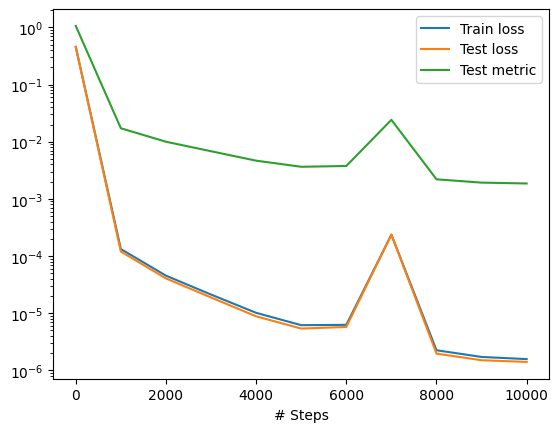

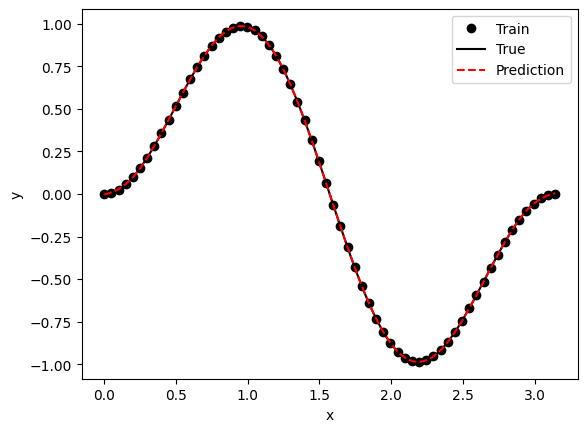

In [30]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [31]:
def spherical_harmonic_model(x):
    theta, phi = x[:, 0:1], x[:, 1:2]
    theta_part = model.predict(theta)
    phi_part = z_component(phi)
    
    return theta_part * phi_part

In [32]:
def diff_function(x):
    model_value = spherical_harmonic_model(x)
    true_value = spherical_harmonic(x)
    return np.abs(model_value - true_value)

In [33]:
diff_function(np.array([[0.0, 0.0], [1.0, 0.0]]))

array([[0.00142852],
       [0.00028981]])

In [34]:
def plot_2d_map(plotted_function, grid_dist=0.01):
    x_ax = np.arange(0, np.pi, grid_dist)
    y_ax = np.arange(0, 2 * np.pi, grid_dist)
    grid_x, grid_y = np.meshgrid(x_ax, y_ax)
    
    diff_list = []
    for a, b in zip(grid_x, grid_y):
        pair_list = []
        for x, y in zip(a, b):
            pair_list.append([x, y])
        pairs = np.array(pair_list)
        diff_list.append(np.squeeze(plotted_function(pairs)))

    diff_list = np.abs(np.array(diff_list))
    
    im = plt.imshow(diff_list, cmap=plt.cm.RdBu)
    plt.colorbar(im)

    plt.show()

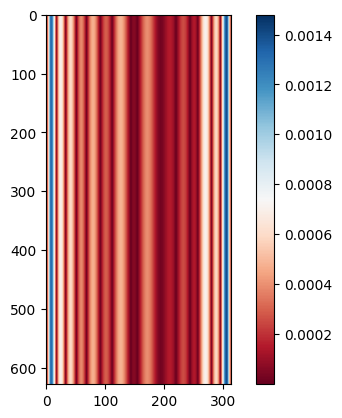

In [35]:
plot_2d_map(diff_function)

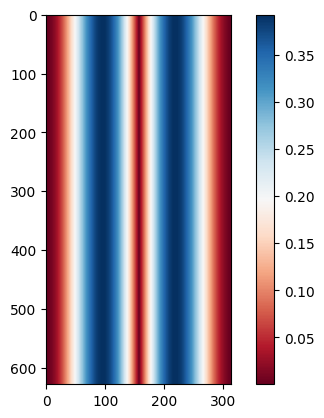

In [36]:
plot_2d_map(spherical_harmonic_model)

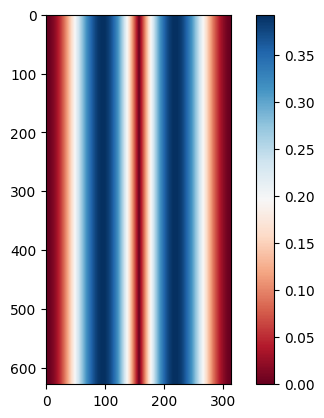

In [37]:
plot_2d_map(spherical_harmonic)